## LinkedIn API Access

In [ ]:
from linkedin_v2 import linkedin

API_KEY   = ''
API_SECRET = ''

RETURN_URL = 'http://localhost:8888'

authentication = linkedin.LinkedInAuthentication(API_KEY, API_SECRET, RETURN_URL, ['r_liteprofile'])

print(authentication.authorization_url)  # open this url on your browser

## Retrieving your LinkedIn profile

In [ ]:
authentication.authorization_code = ''
result = authentication.get_access_token()

In [ ]:
app = linkedin.LinkedInApplication(token=result.access_token)

## Download your profile data and read in connections data as a CSV file

In [1]:
import os
import csv

# Point this to your 'Connections.csv' file.
CSV_FILE = os.path.join('data', 'Connections.csv')

csvReader = csv.DictReader(open(CSV_FILE, encoding='utf-8-sig'), delimiter=',', quotechar='"')
contacts = [row for row in csvReader]

In [2]:
#contacts

## Simple normalization of company suffixes from address book data

In [3]:
from prettytable import PrettyTable # pip install prettytable
from collections import Counter
from operator import itemgetter

# Define a set of transforms that converts the first item
# to the second item. Here, we're simply handling some
# commonly known abbreviations, stripping off common suffixes, 
# etc.

transforms = [(', Inc.', ''), (', Inc', ''), (', LLC', ''), (', LLP', ''),
               (' LLC', ''), (' Inc.', ''), (' Inc', ''), (' AG', ''), (' Ltd', ''), ('NNE', 'Pharmaplan')]

companies = [c['Company'].strip() for c in contacts if c['Company'].strip() != '']

for i, _ in enumerate(companies):
    for transform in transforms:
        companies[i] = companies[i].replace(*transform)

pt = PrettyTable(field_names=['Company', 'Freq'])
pt.align = 'l'
c = Counter(companies)

#print(c)

[pt.add_row([company, freq]) for (company, freq) in sorted(c.items(), key=itemgetter(1), reverse=True) if freq > 1]

print(pt)

+-----------------------------------------+------+
| Company                                 | Freq |
+-----------------------------------------+------+
| Pharmaplan                              | 24   |
| National Technical University of Athens | 3    |
| Zaha Hadid Architects                   | 2    |
| EM2N                                    | 2    |
| Hodkinson Consultancy                   | 2    |
+-----------------------------------------+------+


## Standardizing common job titles and computing their frequencies

In [4]:
transforms = [
    ('Sr.', 'Senior'),
    ('Sr', 'Senior'),
    ('Jr.', 'Junior'),
    ('Jr', 'Junior'),
    ('CEO', 'Chief Executive Officer'),
    ('COO', 'Chief Operating Officer'),
    ('CTO', 'Chief Technology Officer'),
    ('CFO', 'Chief Finance Officer'),
    ('VP', 'Vice President'),
    ('Architekt', 'Architect'),
    ]

# Read in a list of titles and split apart
# any combined titles like "President/CEO."
# Other variations could be handled as well, such
# as "President & CEO", "President and CEO", etc.

titles = []
for contact in contacts:
    titles.extend([t.strip() for t in contact['Position'].split('/')
                  if contact['Position'].strip() != ''])

# Replace common/known abbreviations

for i, _ in enumerate(titles):
    for transform in transforms:
        titles[i] = titles[i].replace(*transform)

# Print out a table of titles sorted by frequency

pt = PrettyTable(field_names=['Job Title', 'Freq'])
pt.align = 'l'
c = Counter(titles)
[pt.add_row([title, freq]) 
 for (title, freq) in sorted(c.items(), key=itemgetter(1), reverse=True) 
     if freq > 1]
print(pt)

# Print out a table of tokens sorted by frequency

tokens = []
for title in titles:
    tokens.extend([t.strip(',') for t in title.split()])
pt = PrettyTable(field_names=['Token', 'Freq'])
pt.align = 'l'
c = Counter(tokens)
[pt.add_row([token, freq]) 
 for (token, freq) in sorted(c.items(), key=itemgetter(1), reverse=True) 
     if freq > 2 and len(token) > 2]
print(pt)

+---------------------+------+
| Job Title           | Freq |
+---------------------+------+
| Architect           | 23   |
| Junior Architect    | 4    |
| Project Architect   | 4    |
| Project Engineer    | 3    |
| Architect Engineer  | 3    |
| Senior Architect    | 3    |
| Assistant Professor | 3    |
| Lead Engineer       | 2    |
| Director            | 2    |
| Teaching Assistant  | 2    |
| Designer            | 2    |
| Urban Designer      | 2    |
| Founder             | 2    |
| Co-Founder          | 2    |
+---------------------+------+
+---------------+------+
| Token         | Freq |
+---------------+------+
| Architect     | 46   |
| Engineer      | 21   |
| Project       | 17   |
| Senior        | 13   |
| Assistant     | 12   |
| Manager       | 10   |
| Designer      | 8    |
| Director      | 7    |
| Specialist    | 7    |
| Professor     | 7    |
| Design        | 7    |
| Junior        | 5    |
| Research      | 5    |
| Architectural | 5    |
| Team          |

## Geocoding locations with OpenStreetMap

In [5]:
import osmnx as ox
import matplotlib.pyplot as plt
%matplotlib inline

# Specify the name that is used to seach for the data
place_name = "Altstadt, Zürich, Switzerland"

# Fetch OSM street network from the location
graph = ox.graph_from_place(place_name)
type(graph)

networkx.classes.multidigraph.MultiDiGraph

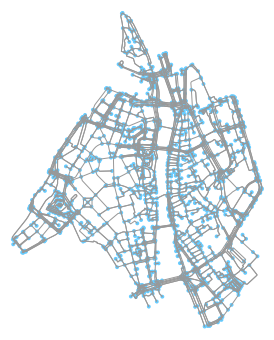

In [6]:
# Plot the streets
fig, ax = ox.plot_graph(graph)

In [7]:
import geocoder
location = geocoder.osm("ETH Zürich")

In [8]:
location.json

{'accuracy': 0.6981613543024849,
 'address': 'ETH Zürich, 101, Rämistrasse, Hochschulen, Altstadt, Zürich, Bezirk Zürich, Zürich, 8092, Schweiz/Suisse/Svizzera/Svizra',
 'bbox': {'northeast': [47.3771723, 8.5487892],
  'southwest': [47.3756849, 8.5468475]},
 'city': 'Zürich',
 'confidence': 10,
 'country': 'Schweiz/Suisse/Svizzera/Svizra',
 'country_code': 'ch',
 'county': 'Bezirk Zürich',
 'housenumber': '101',
 'importance': 0.6981613543024849,
 'lat': 47.3764534,
 'lng': 8.54770931489751,
 'ok': True,
 'osm_id': 192151232,
 'osm_type': 'way',
 'place_id': 255254827,
 'place_rank': 30,
 'postal': '8092',
 'quality': 'university',
 'raw': {'place_id': 255254827,
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
  'osm_type': 'way',
  'osm_id': 192151232,
  'boundingbox': ['47.3756849', '47.3771723', '8.5468475', '8.5487892'],
  'lat': '47.3764534',
  'lon': '8.54770931489751',
  'display_name': 'ETH Zürich, 101, Rämistrasse, Hochschulen, Altstadt, 

In [9]:
from geopy.geocoders import Nominatim

g = Nominatim(user_agent="https://ganagno.github.io/")

location = g.geocode("ETH Zürich")
print(location)
print('Lat/Lon: {0}, {1}'.format(location.latitude,location.longitude))
print('https://www.google.ca/maps/@{0},{1},17z'.format(location.latitude,location.longitude))

ETH Zürich, 101, Rämistrasse, Hochschulen, Altstadt, Zürich, Bezirk Zürich, Zürich, 8092, Schweiz/Suisse/Svizzera/Svizra
Lat/Lon: 47.3764534, 8.54770931489751
https://www.google.ca/maps/@47.3764534,8.54770931489751,17z


## Geocoding locations of LinkedIn connections with Nominatim

In [10]:
for i, c in enumerate(contacts):
    progress = '{0:3d} of {1:3d} - '.format(i+1,len(contacts))
    company = c['Company']
    try:
        location = g.geocode(company, addressdetails=True)
    except:
        print('... Failed to get a location for {0}'.format(company))
        location = None
    
    if location != None:
        c.update([('Location', location)])
        #print(progress + company[:50] + ' -- ' + location.address)
    else:
        c.update([('Location', None)])
        #print(progress + company[:50] + ' -- ' + 'Unknown Location')

## Parsing out states from location results

In [11]:
import json
import codecs

In [13]:
def checkIfUSA(loc):
    if loc == None: return False
    for key, value in loc.raw['address'].items():
        if 'country' in key:
            if value == 'USA':
                return True
            else:
                return False
    

def parseStateFromOpenStreetMapsLocation(loc):
    try:
        for key, value in loc.raw['address'].items():
            if 'state' in key:
                return value
    except:
        return None
    
results = {}

for c in contacts:
    loc = c['Location']
    if loc == None: continue
    if not checkIfUSA(loc): continue 
    state = parseStateFromOpenStreetMapsLocation(loc)
    if state == None: continue
    results.update({loc.address : state})
    
print(json.dumps(results, indent=1))

{
 "Self Employed, Kittitas County, Washington, USA": "Washington",
 "Taylor, Chapman Lake, Lackawanna County, Pennsylvania, 18433, USA": "Pennsylvania",
 "Nike Seattle, 1500, 6th Avenue, Central Business District, First Hill, Seattle, King County, Washington, 98101, USA": "Washington",
 "Rundquist Court, Rockford, Winnebago County, Illinois, 61114, USA": "Illinois",
 "AECOM, 3101, Wilson Boulevard, Clarendon, Arlington, Arlington County, Virginia, 22205, USA": "Virginia"
}


## Write the data to a JSON file, storing the address, latitude, and longitude data for location

In [14]:
CONNECTIONS_DATA = 'linkedin_connections.json'

# Loop over contacts and update the location information to store the
# string address, also adding latitude and longitude information
def serialize_contacts(contacts, output_filename):
    for c in contacts:
        location = c['Location']
        if location != None:
            # Convert the location to a string for serialization
            c.update([('Location', location.raw['address'])])
            c.update([('Lat', location.raw['lat'])])
            c.update([('Lon', location.raw['lon'])])

    output_file = codecs.open(output_filename, "w", encoding="utf-8")
    json.dump(contacts, output_file, indent=4, ensure_ascii=False)
    return

serialize_contacts(contacts, CONNECTIONS_DATA)

### Here's how to power a Cartogram visualization with the data from the "results" variable

In [15]:
# Load in a data structure mapping state names to codes.
codes = json.loads(open('states-codes.json').read())

In [16]:
from collections import Counter
c = Counter([r[1] for r in results.items()])
c.items()

dict_items([('Washington', 2), ('Pennsylvania', 1), ('Illinois', 1), ('Virginia', 1)])

In [17]:
states_freqs = { k : v for (k,v) in c.items() }
states_freqs

{'Washington': 2, 'Pennsylvania': 1, 'Illinois': 1, 'Virginia': 1}

In [18]:
# Lace in all of the other states and provide a minimum value for each of them
states_freqs.update({v : 0.2 for v in codes.values() if v not in states_freqs.keys() })

In [19]:
# Write output to file
f = open('states-freqs.json', 'w')
f.write(json.dumps(states_freqs, indent=1))
f.close()

In [20]:
from IPython.display import display, Javascript, HTML

In [21]:
%%html
<meta charset="utf-8">
<div id="d3-example"></div>
<style>
circle {
  fill: #eee;
  stroke: #000;
  stroke-width: 1.5px;
}
text {
  font: 10px sans-serif;
}
</style>

In [22]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths:
    {d3: "http://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {
  // The code in this block is executed when the
  // d3.js library has been loaded.

  // First, we specify the size of the canvas
  // containing the visualization (size of the
  // <div> element).    
    
  var margin = {top: 0, right: 0, bottom: 0, left: 0},
      width = 960 - margin.left - margin.right,
      height = 500 - margin.top - margin.bottom,
      padding = 3;  

  var projection = d3.geo.albersUsa();   
    
  var radius = d3.scale.sqrt()
      .domain([0, 10])
      .range([0, 30]);
    
  var force = d3.layout.force()
      .charge(0)
      .gravity(0)
      .size([width, height]);
    
  var svg = d3.select("#d3-example").append("svg")
      .attr("width", width + margin.left + margin.right)
      .attr("height", height + margin.top + margin.bottom)
    .append("g")
      .attr("transform", "translate(" + margin.left + "," + margin.top + ")");
    
    
  // Load data
  var statesToFreqs = null;
  d3.json("states-freqs.json", function(error, sf) {
      statesToFreqs = sf;
      console.log(sf);
  });    

  d3.json("us-states-centroids-simple.json", function(error, states) {
    if (error) throw error;
      
    console.log(states);

    var nodes = [];
    let s = 0;
    for (s in states) {
      try {
        console.log(states[s]);
        var point = projection(states[s]);
        var value = statesToFreqs[s];
        var node = {
            x : point[0], y : point[1],
            x0 : point[0], y0 : point[1],
            r : radius(value),
            value : value,
            name : s
        };
        nodes.push(node);
      } catch (e) { /* pass */}
    }
    
    force
        .nodes(nodes)
        .on("tick", tick)
        .start();
      
    // We create a <circle> SVG element for each node
    // in the graph, and we specify a few attributes.      
    var node = svg.selectAll("circle")
        .data(nodes)
      .enter().append("circle")
        .attr("r", function(d) { return d.r; });;    
      
    // The name of each node is the node number.
    node.append("title").text(function(d) { return d.name }); 
      
    function tick(e) {
      node.each(gravity(e.alpha * .1))
          .each(collide(.5))
          .attr("cx", function(d) { return d.x; })
          .attr("cy", function(d) { return d.y; });
    }
      
      
    function gravity(k) {
      return function(d) {
        d.x += (d.x0 - d.x) * k;
        d.y += (d.y0 - d.y) * k;
      };
    }
      
    function collide(k) {
      var q = d3.geom.quadtree(nodes);
      return function(node) {
        var nr = node.r + padding,
            nx1 = node.x - nr,
            nx2 = node.x + nr,
            ny1 = node.y - nr,
            ny2 = node.y + nr;
        q.visit(function(quad, x1, y1, x2, y2) {
          if (quad.point && (quad.point !== node)) {
            var x = node.x - quad.point.x,
                y = node.y - quad.point.y,
                l = x * x + y * y,
                r = nr + quad.point.r;
            if (l < r * r) {
              l = ((l = Math.sqrt(l)) - r) / l * k;
              node.x -= x *= l;
              node.y -= y *= l;
              quad.point.x += x;
              quad.point.y += y;
            }
          }
          return x1 > nx2 || x2 < nx1 || y1 > ny2 || y2 < ny1;
        });
      };
    }      
  });
});

<IPython.core.display.Javascript object>

## Clustering job titles using a greedy heuristic

In [23]:
from nltk.util import bigrams

ceo_bigrams = list(bigrams("Chief Executive Officer".split(), pad_left=True, pad_right=True))
cto_bigrams = list(bigrams("Chief Technology Officer".split(), pad_left=True, pad_right=True))

print(ceo_bigrams)
print(cto_bigrams)

print(len(set(ceo_bigrams).intersection(set(cto_bigrams))))

[(None, 'Chief'), ('Chief', 'Executive'), ('Executive', 'Officer'), ('Officer', None)]
[(None, 'Chief'), ('Chief', 'Technology'), ('Technology', 'Officer'), ('Officer', None)]
2


### Jaccard distance calculation

In [24]:
from nltk.metrics.distance import jaccard_distance # pip install nltk

job_title_1 = 'Chief Executive Officer'.split()
job_title_2 = 'Chief Technology Officer'.split()

print(job_title_1)
print(job_title_2)

print()
print('Intersection:')
intersection = set(job_title_1).intersection(set(job_title_2))
print(intersection)

print()
print('Union:')
union = set(job_title_1).union(set(job_title_2))
print(union)

print()
print('Similarity:', len(intersection) / len(union))
print('Distance:', jaccard_distance(set(job_title_1), set(job_title_2)))

['Chief', 'Executive', 'Officer']
['Chief', 'Technology', 'Officer']

Intersection:
{'Officer', 'Chief'}

Union:
{'Chief', 'Executive', 'Technology', 'Officer'}

Similarity: 0.5
Distance: 0.5


In [25]:
job_title_1 = 'Vice President, Sales'.split()
job_title_2 = 'Vice President, Customer Relations'.split()

print(job_title_1)
print(job_title_2)

print()
print('Intersection:')
intersection = set(job_title_1).intersection(set(job_title_2))
print(intersection)

print()
print('Union:')
union = set(job_title_1).union(set(job_title_2))
print(union)

print()
print('Similarity:', len(intersection) / len(union))
print('Distance:', jaccard_distance(set(job_title_1), set(job_title_2)))

['Vice', 'President,', 'Sales']
['Vice', 'President,', 'Customer', 'Relations']

Intersection:
{'Vice', 'President,'}

Union:
{'Customer', 'Relations', 'Sales', 'Vice', 'President,'}

Similarity: 0.4
Distance: 0.6


In [26]:
import os
import csv

# Point this to your 'Connections.csv' file.
CSV_FILE = os.path.join('data', 'Connections.csv')

csvReader = csv.DictReader(open(CSV_FILE, encoding='utf-8-sig'), delimiter=',', quotechar='"')
contacts = [row for row in csvReader]

In [27]:
#contacts

In [28]:
transforms = [
    ('Sr.', 'Senior'),
    ('Sr', 'Senior'),
    ('Jr.', 'Junior'),
    ('Jr', 'Junior'),
    ('CEO', 'Chief Executive Officer'),
    ('COO', 'Chief Operating Officer'),
    ('CTO', 'Chief Technology Officer'),
    ('CFO', 'Chief Finance Officer'),
    ('VP', 'Vice President'),
    ('Architekt', 'Architect'),
    ('ARCHITECT', 'Architect'),
    
    ]

separators = [' / ', ' and ', '|', ',' ,'&', '_ ', ' - ', ' I ', ' (UK/ARB- GR/TEE)', '/',  '(Pharma Process)', 'Project-',  ': ']

# Normalize and/or replace known abbreviations
# and build up a list of common titles.

all_titles = []
for i, _ in enumerate(contacts):
    if contacts[i]['Position'] == '':
        contacts[i]['Position'] = ['']
        continue
    titles = [contacts[i]['Position']]
    for separator in separators:
        for title in titles:
            if separator in title:
                titles.remove(title)
                titles.extend([title.strip() for title in title.split(separator) if title.strip() != ''])
    for transform in transforms:
        titles = [title.replace(*transform) for title in titles]
        titles = [title.strip() for title in titles]

    contacts[i]['Position'] = titles
    all_titles.extend(titles)

In [29]:
#all_titles

In [30]:
for i, c in enumerate(contacts):
    text = '{0:3d} {1}'.format(i+1,c['Position'])    
    print(text)

  1 ['Senior Project Manager', 'Team Leader']
  2 ['Lead Engineer']
  3 ['']
  4 ['Director Project Governance']
  5 ['Keep in Touch via Social Platforms']
  6 ['Specialist']
  7 ['Project Engineer']
  8 ['Architect']
  9 ['Architect']
 10 ['Lead REVIT P3D E3D PDMS SP3D PDS Truth seeker', 'Change Magician']
 11 ['Graduate Area Manager']
 12 ['Assistant Professor in Computational Design', 'Digital Fabrication']
 13 ['Head of PM Department', 'Project Director']
 14 ['Clean Utilities Senior Specialist', 'Team Leader']
 15 ['Design Project Engineer']
 16 ['Sales Director']
 17 ['Account Manager']
 18 ['Engineer Biotechnology']
 19 ['Senior Project Engeneer']
 20 ['Senior Engineer', 'Team Leader']
 21 ['Project Engineer']
 22 ['Project Assistant']
 23 ['Junior Architect']
 24 ['Security Engineer']
 25 ['Portfolio Management', 'Consultant']
 26 ['Construction Site Manager']
 27 ['BIM Coordinator']
 28 ['Project Engineer']
 29 ['Qualification Engineer']
 30 ['Laboratory Research Trainee']
 31